In [59]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Lambda, Reshape # Lambda --> to do some mathamatics within the model;
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

In [60]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [61]:
# normalizing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_test = X_test / 255

In [62]:
X_train.shape

(60000, 28, 28)

In [63]:
# reshaping 
img_width = X_train.shape[1] # 28
img_height = X_train.shape[2] # 28
num_channels = 1 # as greyscale image;

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, num_channels)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

In [64]:
X_train.shape

(60000, 28, 28, 1)

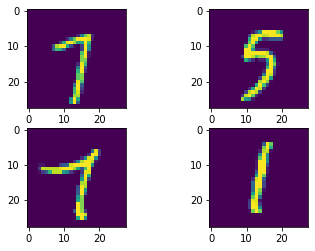

In [65]:
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[42][:,:,0])

plt.subplot(222)
plt.imshow(X_train[420][:,:,0])

plt.subplot(223)
plt.imshow(X_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42000][:,:,0])
plt.show()

In [66]:
# dimention of latent vector, 2D --> blurry, 10,11,..D --> very sharp recontracted image, but u have to deal with 10 dimensions;
latent_dim = 2

# encoder
input_img = Input(shape=input_shape, name='encoder_input') # name='encoder_input' --> just giving a name to the input layer of encoder;
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) # shows the tensor shape after the convolution operations; doing this as because, after the encoder and the decoder i want my input shapes to be matched; shape of conv to be provided to decoder

x = Flatten()(x) # flattening the conv. layer
x = Dense(32, activation = 'relu')(x) # adding a dense layer

In [67]:
# definig the mu and sigma for the Z(nor. std. distri.)
z_mu = Dense(latent_dim, name='latent_mu')(x)   # mean values of encoded input;
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  # std dev. (variance) of encoded input;
# they both are exactly same, as because they are learned during back propagation;

In [68]:
# reperemeterized trick --> Define sampling function to sample from the distribution, reparameterize sample based on the process defined by Gunderson and Huang into the shape of 'mu + sigma squared x eps'; this is to allow gradient descent to allow for gradient estimation accurately; 
def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

In [69]:
# just defining the (Z), how to sample from mu & sigma;
z = Lambda(sample_z, output_shape = (latent_dim,), name = 'z')([z_mu, z_sigma])
# z is the lambda custom layer, also being the last layer in the encoder part;


In [70]:
# all the layers of encoder defined above individually, now group them toder into a model named 'Encoder';
encoder = Model(input_img, [z_mu, z_sigma, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_21 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_21[0][0]']           
                                                                                            

In [71]:
# decoder part;
# decoder takes the sampled-latent_vector(z) as input

In [72]:
decoder_input = Input(shape = (latent_dim,), name = 'decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation = 'relu')(decoder_input) # i need to match the size of conv. layers into the decoder layers, so, our final utput to be same shape original input;
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x) # reshape to the shape of last conv. layer in the encoder;

x = Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x) # upscaling as regular AE;
x = Conv2DTranspose(num_channels, 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x) # last layer(output layer), if u want, u can add many upscaling layers before this;

decoder = Model(decoder_input, x, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_2 (Reshape)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289       
 spose)                                                          
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (22

In [73]:
# adding the latent sample to the decoder;
z_decoded = decoder(z)

In [74]:
# now, defining the custom loss function of VAE, as VAE takes 2 loss fucntions --> (reconstruction loss + KL Divergence)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded) # reconstruction loss, nothing but binary-crossentropy;
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1) # KL divergence;
        
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded) # adding the losses to the encoder part(x) and decoder(z_decoded);
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomLayer()([input_img, z_decoded]) # y is actually the input image, after it goes through the encoder part(input image + mu + sigma + z) and decoder part; this would be used as output for VAE;

In [75]:
vae = Model(input_img, y, name = 'vae') # input_img--> x, y --> y
vae.compile(optimizer = 'adam', loss = None) # loss = None --> as y already gone through loss(Recons. + VL) anyhow;
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_21 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_21[0][0]']           
                                                                                                

In [76]:
# training the VAE;
vae.fit(X_train, None, epochs = 3, batch_size = 10, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - ETA: 0s - loss: 0.2152

C:\python_arpan\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 186s 4ms/sample - loss: 0.2152 - val_loss: 0.2006
Epoch 2/3
48000/48000 [==============================] - 200s 4ms/sample - loss: 0.1967 - val_loss: 0.1928
Epoch 3/3
48000/48000 [==============================] - 213s 4ms/sample - loss: 0.1918 - val_loss: 0.1897


In [78]:
mu, _, _ = encoder.predict(X_test) #  encoder.predict(X_test) --> returns 3 things, mu, sigma nad z , now only looking into mu;

C:\python_arpan\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


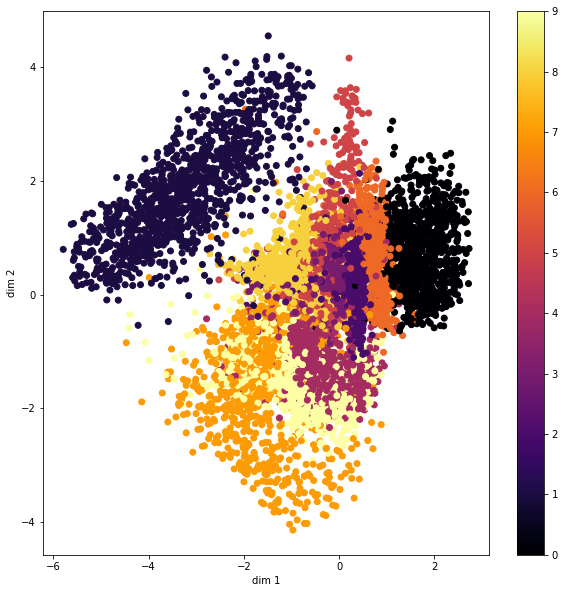

In [91]:
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='inferno')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

# latent space range is about -6 to 4, so pick random values within this range; starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from one image to the other;

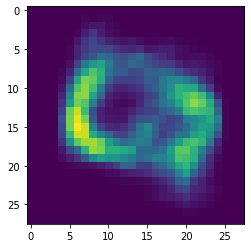

In [80]:
sample_vector = np.array([[1,-1]]) # i am providing a latent vector; should come --> (0 or random noise)
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

# output came as something which is mixture of noise and 0;

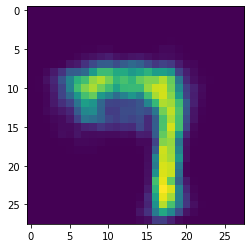

In [81]:
sample_vector = np.array([[0,-3]]) # should come 7
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

# came something, what is looks like 7;

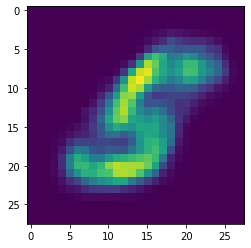

In [82]:
sample_vector = np.array([[0,1.5]]) # should come 5
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

# came something, what is looks like 5;

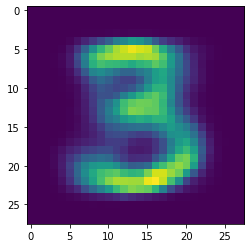

In [83]:
sample_vector = np.array([[0,0]]) # should come 2-->3
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

# came something, what is looks like 3;

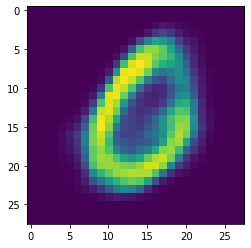

In [85]:
sample_vector = np.array([[1,1]]) # should come 0 and 6
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

# came something, what is looks like trying to be 0 but from 6; means, 6 is becoming 0;

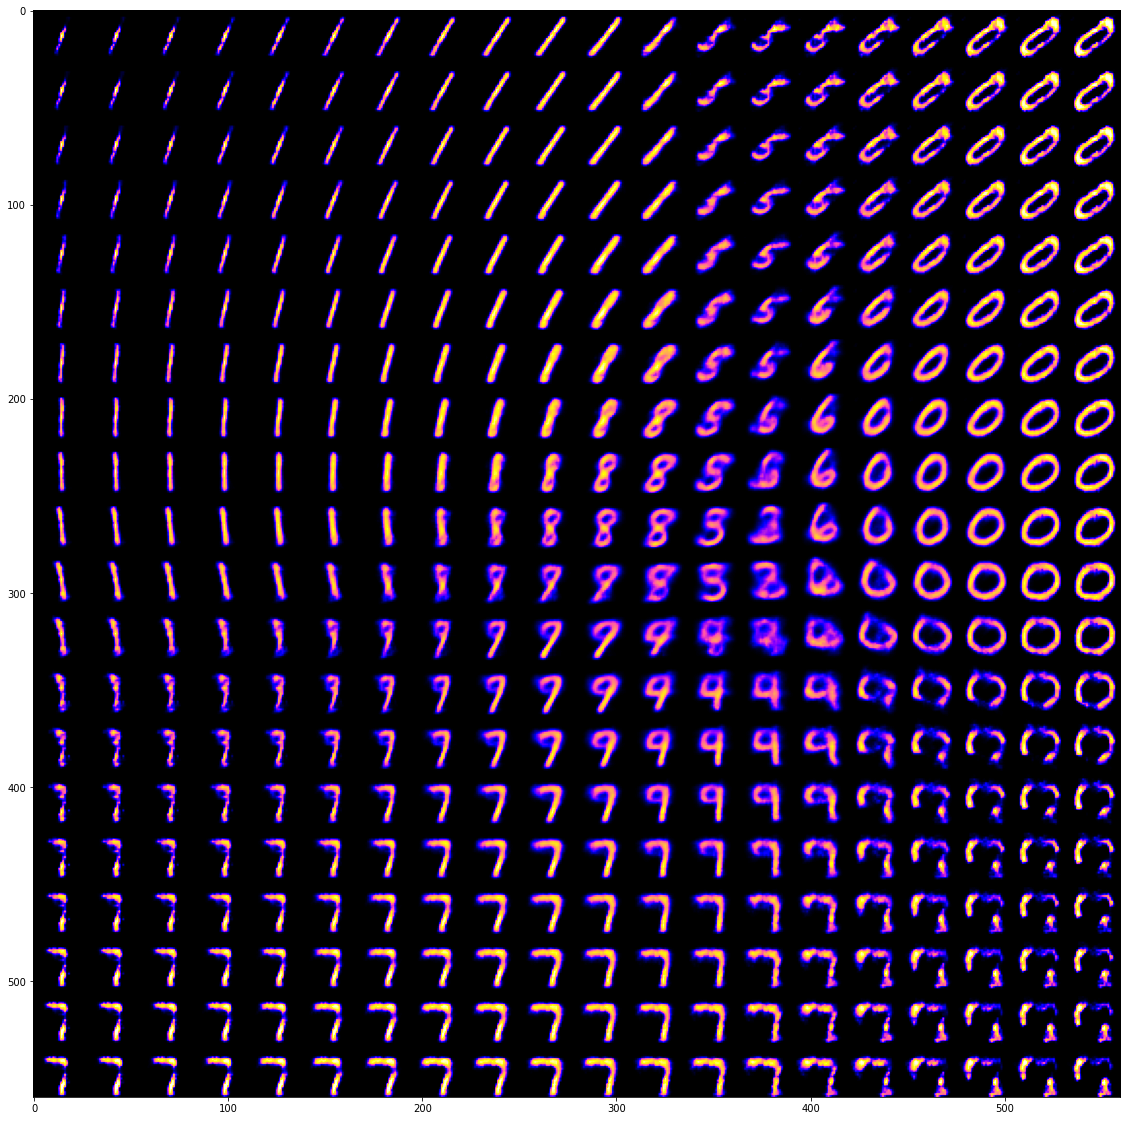

In [92]:
# MORPHING HAS BEEN SEEN;

# to see this morphing into a great amount, less automate this lask;

n = 20  
figure = np.zeros((img_width * n, img_height * n, num_channels))

grid_x = np.linspace(-6, 3, n) # creating vectors within range -6 to 3 as that seems to be the range in latent space
grid_y = np.linspace(-4.8, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(20, 20))

# reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  